In [1]:
#imports
import cv2
print(cv2.__version__)
import numpy as np
import os
import re
import natsort
import shutil

from PIL import Image
import glob

4.2.0


In [2]:
#got this function from: https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):

    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow

        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()

    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)

        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

In [3]:
img_height = 1000

#movie_name
video_name = 'up'

#video
vidcap = cv2.VideoCapture('up.mp4')

#frames - how many frames of the movie we want to capture
frame_count = 6400

In [4]:
#make directory for video_name/raw_frames
cwd = os.getcwd()
raw_frames_cwd = os.path.join(cwd, video_name, 'raw_frames')

os.makedirs(raw_frames_cwd);

In [5]:
#this takes the video, and turns each frame into a jpg file stored in the working directory
success,image = vidcap.read()

count = 1

#this gets the amount to skip the video by for each frame
length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
modulus_value = (length // frame_count)

print('this is the length of the video in frames: ', length)

while success and count <= frame_count:
    
    frame_name = 'frame_{}.png'.format(count)
    
    cv2.imwrite(frame_name, image)     # save frame as JPEG file
    
    #moving the file over to the raw_frames folder for the video
    source = os.path.join(cwd, frame_name)
    destination = raw_frames_cwd
    shutil.move(source, destination);
    
    #skip the video by the necessaary amount
    vidcap.set(cv2.CAP_PROP_POS_FRAMES,(count*modulus_value))
    #read it in again
    success,image = vidcap.read()
          
    count += 1

print('made {} frames'.format(frame_count))

this is the length of the video in frames:  126961
made 6400 frames


In [6]:
#this gets all of the created frames and moves them to a list
raw_wd = glob.glob('{}/*.png'.format(raw_frames_cwd))
raw_frames_list = [frame for frame in raw_wd if 'frame' in frame]

raw_frames_sorted = natsort.natsorted(raw_frames_list,reverse=False)
length_of_raw_frames = len(raw_frames_sorted)
print(length_of_raw_frames)

6400


In [7]:
#create a new filepath for all the contrasted frames
contrasted_frames_cwd = os.path.join(cwd, video_name, 'contrasted_frames')

os.makedirs(contrasted_frames_cwd);

count = 1

for frame in raw_frames_sorted:
    path_to_current_frame = os.path.join(raw_frames_cwd, frame)
    img = cv2.imread(path_to_current_frame)
    
    #apply contrast
    final = apply_brightness_contrast(img, 0, 10)
    
    #save picture
    contrasted_frame_name = 'contrasted_frame_{}.png'.format(count)
    
    cv2.imwrite(contrasted_frame_name, final)
    
    #move it over to the contrasted_frames directory
    source = os.path.join(cwd, contrasted_frame_name)
    destination = contrasted_frames_cwd
    shutil.move(source, destination);
        
    count += 1

In [8]:
#this gets all of the contrasted png's and moves them to a list
contrasted_frames = []
for movie_frames in os.listdir(contrasted_frames_cwd):
    if movie_frames.endswith('.png'):
            contrasted_frames.append(movie_frames)
        

#organize the frames to be ascending
contrasted_frames_sorted = natsort.natsorted(contrasted_frames,reverse=False)
length_of_contrasted_frames = len(contrasted_frames_sorted)

In [9]:
#create a new filepath for all the refactored frames
refactored_frames_cwd = os.path.join(cwd, video_name, 'refactored_frames')

os.makedirs(refactored_frames_cwd);

count = 1

#these are the final demnsions for the refactored frames which are 1x1000 each
width = 1
height = img_height
dim = (width, height)

for frame in contrasted_frames_sorted:
    if count <= 10000: #some random large number -- needs to be > than frame_count
        path_to_current_frame = os.path.join(contrasted_frames_cwd, frame)

        img = cv2.imread(path_to_current_frame)
        
        #resize 3 different times, gradually reducing the size to the desired 1-pixel wide
        resized_once = cv2.resize(img, (250,height), interpolation = cv2.INTER_CUBIC + cv2.INTER_AREA)
        
        resized_twice = cv2.resize(resized_once, (30,height), interpolation = cv2.INTER_CUBIC + cv2.INTER_AREA)

        resized = cv2.resize(resized_twice, dim, interpolation = cv2.INTER_CUBIC + cv2.INTER_AREA)
        
        #save the picture
        refactored_name = 'refactored_frame_{}.png'.format(count)
        
        cv2.imwrite(refactored_name, resized)
        
        #move it over to the refactored_frames dir
        source = os.path.join(cwd, refactored_name)
        destination = refactored_frames_cwd
        shutil.move(source, destination);
        
        count = count + 1
    else:
        exit()
        

In [10]:
#organize the refactored frames to be in order, as they need to get inputted in order
full_wd = glob.glob('{}/*.png'.format(refactored_frames_cwd))
refactored_frames = [frame for frame in full_wd if 'refactored' in frame]

list_of_frames_sorted_refactor = natsort.natsorted(refactored_frames,reverse=False)

length_of_refactor = len(list_of_frames_sorted_refactor)

#read in 1 frame to get its dimensions
base_image = Image.open('{}/refactored_frame_1.png'.format(refactored_frames_cwd))

#this creates the base for the final image, which will have the height of the singular frame, with the width of the singular frame * the amount of frames we've decided on
final_image = Image.new('RGB', (base_image.width * length_of_refactor, base_image.height))

count = 0

#pastes the new image to the final image
for image in list_of_frames_sorted_refactor:
    image_opened = Image.open(image)
    final_image.paste(image_opened, (int(base_image.width*count),0))
    count = count + 1

#saves the barcoded image
final_image_barcode = '{0}_barcode.png'.format(video_name)

final_image.save(final_image_barcode)

#create a new folder for the completed barcode
final_images_cwd = os.path.join(cwd, video_name, 'final_images')
os.makedirs(final_images_cwd);

#move the final_image to the final_images directory
source = os.path.join(cwd, final_image_barcode)
destination = final_images_cwd
shutil.move(source, destination);

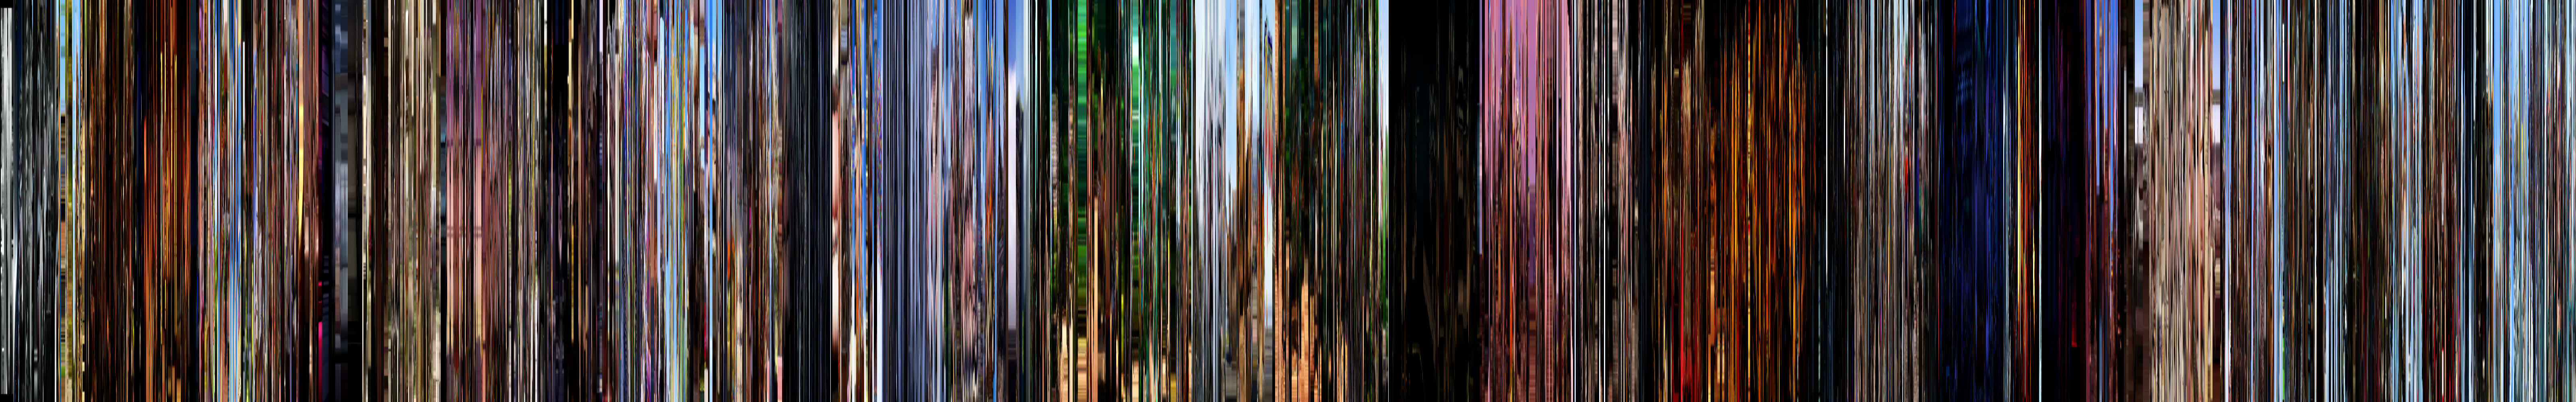

In [11]:
final_image = final_images_cwd + '/' + '{0}_barcode.png'.format(video_name)
displayed_image = Image.open(final_image)
displayed_image

In [12]:
#store data from this notebook to be read by the circular notebook
%store video_name
%store cwd
%store final_images_cwd
%store final_image_barcode

Stored 'video_name' (str)
Stored 'cwd' (str)
Stored 'final_images_cwd' (str)
Stored 'final_image_barcode' (str)


In [13]:
#run the conversion of barcode to iris
%run linear_to_circular.ipynb